<h1 style="font-size:300%">Iris classification with Nearest Neighbors</h1>

BSHT Michielsen MSc

This notebook demonstrates how to use the [sklearn Nearest Neighbors classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) algorithm to classify iris flowers based on simple measurements of their petals and sepals. The iris is a flower with a particular appearance because it has different parts that are shaped significantly different among the three typical species, see the image below. Therefore, it is relatively easy for a human to identify which species of iris we are dealing with based on the shape of those parts, and it is also relatively easy to let a machine classify them using the same metrics. Note that is a classification problem, so we use the `classifier` variety of nearest neighbors. A `regression` variety exists as well for other problems. The data used in this notebook comes from [UCI Irvine Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Iris). The image below is from https://machinelearninghd.com.

<img src="https://machinelearninghd.com/wp-content/uploads/2021/03/iris-dataset.png" />


First, the versions of the required libraries are shown. It always wise to report the versions of the libraries used so that in case problems arise in the future, one can still go back to a state in which the notebook worked.

In [1]:
import sklearn
import pandas
import seaborn

print("scikit-learn version:", sklearn.__version__)     # 1.1.3
print("pandas version:", pandas.__version__)            # 1.5.1
print("seaborn version:", seaborn.__version__)          # 0.12.1

scikit-learn version: 1.1.3
pandas version: 1.5.1
seaborn version: 0.12.1


# 📦 Data provisioning
In real life your data provisioning is likely to include more steps about data sourcing and data quality, however for demo purposes in this notebook we limit it to merely loading the data using the [pandas read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) function, without any concern over quantity nor quality. The data has 150 observations in 5 columns namely 4 features about the iris flowers and 1 target variable, the name of the iris species.

In [2]:
columns = ["Sepal Length", "Sepal Width", "Petal Length", "Petal Width", "Species"]
df = pandas.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data", names=columns)
df.shape

(150, 5)

# 📃 Sample the data
To get an impression of the data and have a look at the features, a sample of 10 observations from the set is taken. The idea here is that a certain combination of values for the features is more likely to mean a certain species. For example `iris-setosa` seems to have a relatively small `Petal Width` and `iris-versicolor` has a relatively high `Sepal Length`. Knowing this, one could, given the lengths and widths for sepal and petal make an educated guess as to the species by looking at how close its values are to already existing observations. This is the idea of Nearest Neighbors, it looks for "how close" a new observation is to previous known observations. In the second part we look at how many observations there are for each of the classes in the target variable by using a groupby function. Because this dataset is very balanced there are exactly 50 observations for each of the 3 classes.

In [3]:
df.sample(10)

,Sepal Length,Sepal Width,Petal Length,Petal Width,Species
46,5.1,3.8,1.6,0.2,Iris-setosa
47,4.6,3.2,1.4,0.2,Iris-setosa
14,5.8,4.0,1.2,0.2,Iris-setosa
73,6.1,2.8,4.7,1.2,Iris-versicolor
117,7.7,3.8,6.7,2.2,Iris-virginica
75,6.6,3.0,4.4,1.4,Iris-versicolor
13,4.3,3.0,1.1,0.1,Iris-setosa
61,5.9,3.0,4.2,1.5,Iris-versicolor
142,5.8,2.7,5.1,1.9,Iris-virginica
102,7.1,3.0,5.9,2.1,Iris-virginica


In [4]:
group_info = df.groupby(["Species"])["Species"].count()
group_info

Species
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: Species, dtype: int64

# 🛠️ Preprocessing
The step of preprocessing contains several activities to consider before we can start training the algorithm and produce a model that can predict our target variable, in this case the species of an iris flower. 

### 🎯 Target variable
Given that machine learning algorithms work with only numbers and therefore produce only numbers as output, the first thing that needs to be done is ascertaining that the target variable is numeric. A new column named `Species ID` is made, that contains a number for ech of the different `Species`, and that becomes the target variable for our model. The thing it needs to predict. In order to fill the new column `Species ID` a LabelEncoder is used, which produces a unique number for every unique text it finds in the column `Species`. Since there are merely three unique values, the numbers it will give are `0`, `1` and `2`.

In [5]:
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()
df["Species ID"] = encoder.fit_transform(df["Species"])
df.sample(10)

,Sepal Length,Sepal Width,Petal Length,Petal Width,Species,Species ID
22,4.6,3.6,1.0,0.2,Iris-setosa,0
72,6.3,2.5,4.9,1.5,Iris-versicolor,1
55,5.7,2.8,4.5,1.3,Iris-versicolor,1
56,6.3,3.3,4.7,1.6,Iris-versicolor,1
118,7.7,2.6,6.9,2.3,Iris-virginica,2
17,5.1,3.5,1.4,0.3,Iris-setosa,0
60,5.0,2.0,3.5,1.0,Iris-versicolor,1
26,5.0,3.4,1.6,0.4,Iris-setosa,0
103,6.3,2.9,5.6,1.8,Iris-virginica,2
83,6.0,2.7,5.1,1.6,Iris-versicolor,1


### 💡 Feature selection
Perhaps the most important step is 'feature selection', which is the activity of deciding which of the candidate features to use in order to predict the target variable. A common mistake is to just take all features "because knowing more, implies a higher chance of guessing correct", which is not true. Sometimes some features do not help at all, and some even produce noise in the algorithm. It is therefore important to pick only those features that can together explain the variance in the target variable the best. For a classification algorithm that would mean that any feature that has well distinguishable values per class would be good. A way to look for this is by creating a [box plot](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.boxplot.html).

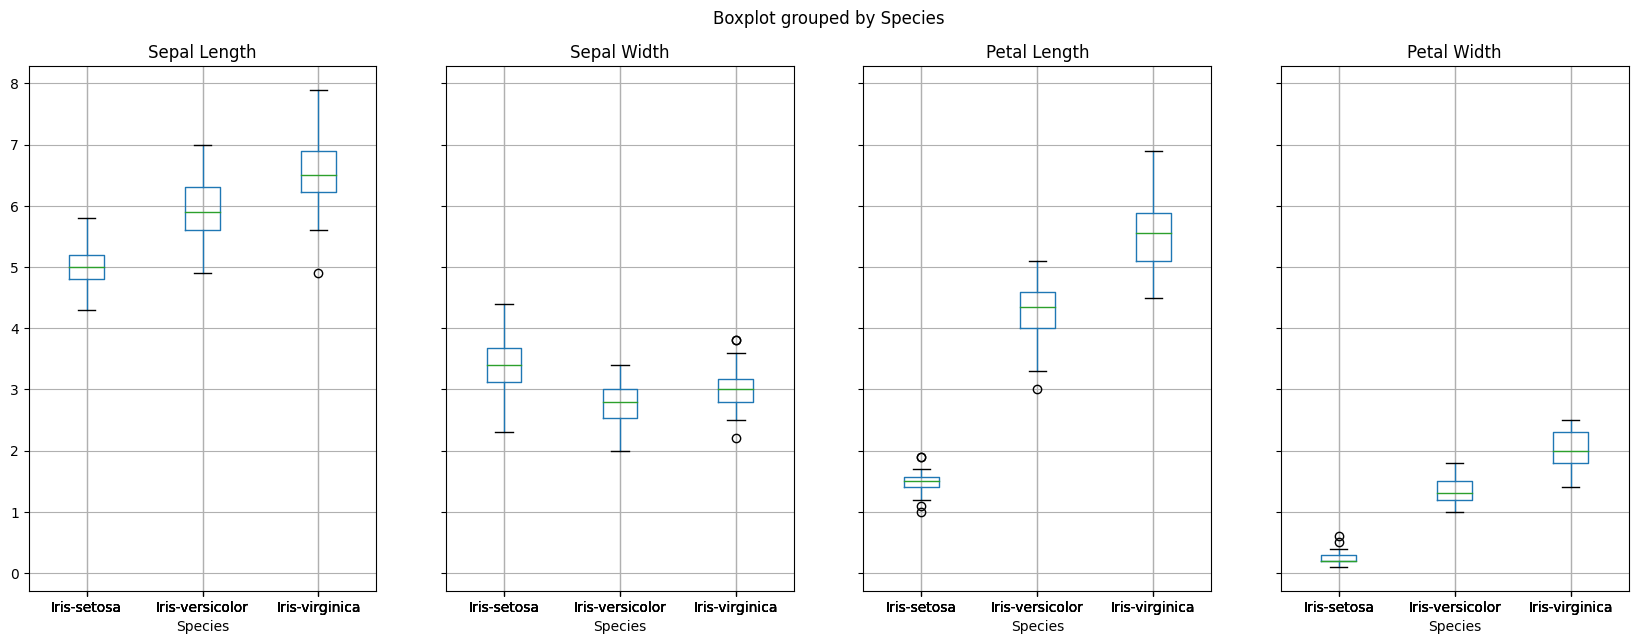

In [6]:
candidates = columns[:-1]
plot = df.boxplot(column=candidates, by="Species", figsize=(20,7), layout=(1,len(candidates)))

The idea here is that if the boxes are vertically close to each other, thus overlapping the same value space, that feature would be less good because the values of that feature are close to each other and therefore hard to distinguish. In contrast, a feature in which the boxes are vertically far away from each other would be a good feature. Now, in this dataset any feature is still a fair choice, but for example `Petal Length`, having boxes far away from each other, would be a better choice than `Sepal Width` where the boxes are closer to each other. Also `Petal Width` seems to be a fair choice. The selected features are put into a variable named `X` and the target variable is put into a variable named `y`.

In [7]:
features = ["Petal Length", "Petal Width"]
target = "Species ID"
X = df[features]
y = df[target]

### 🪓 Splitting into train/test
Before the model can be trained, a little part of the data is to be put aside for testing purposes. The reasoning here is that the model trains with, for example 80% of the data available, and the other 20% is used to ask it to predict the target variable for. Now, because the true target variable of that 20% is known, we can compare the predictions us with the ground truth and devise how well the model performs.

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

There are in total 150 observations, of which 120 are now in the train set, and 30 in the test set.


### ⚖️ Scaling
The Nearest Neighbors algorithm uses the concept of "being near" as to decide which species an unknown iris would be. This "being near" is calculated using [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance), which is an absolute measurement between two values of the same feature, but not among features. It is therefore needed to scale all the features such that they use the same unit of measurement. Here is an example that demonstrates why:
> Given the numbers 6 and 8, the Euclidean distance would be 2. Given the numbers 95 and 100 the Euclidean distance would be 5. However, 95 and 100 are in fact closer to each other (95%) than 6 and 8 are (75%).

Therefore it is important that among features the same unit is used. A common unit to use is [standard deviation](https://en.wikipedia.org/wiki/Standard_deviation), and sklearn provides the `StandardScaler` to transform all values into that same unit. After that we can make a scatter plot to see the actual distances between the iris flowers. Note that the distance is in standard deviations (σ).

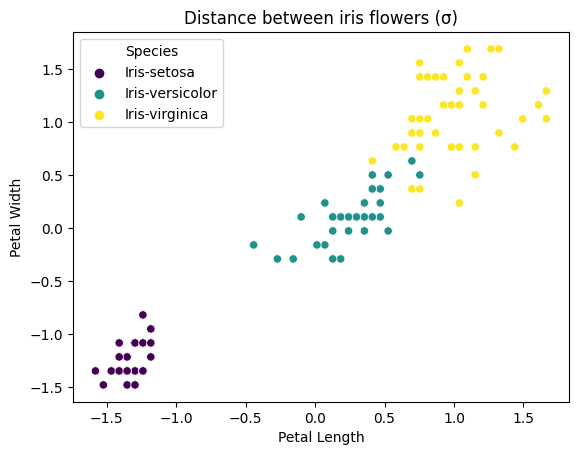

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

plot = seaborn.scatterplot(x=X_train[:,0], y=X_train[:,1], hue=y_train, palette="viridis")
plot.set(xlabel=X.columns[0], ylabel=X.columns[1], title="Distance between iris flowers (σ)")
plot.legend(plot.legend_.legendHandles, df["Species"].unique(), title="Species")

The scatter plot shows that classifying `Iris-setosa` is probably going to be straightforward because it is not like the other 2 species, however `Iris-versicolor` and `Iris-verginica` have some observations that are very close to each other and therefore the model is likely going to have some issues there.

# 🧬 Modelling
In this step only the train set is used to fit the model, which in this case uses a Nearest Neighbors algorithm for classification named [kNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html). And after that the test set is used to calculate the model's accuracy, in other words how well it performs. Accuracy is a fraction where any value closer to 1 is considered better, and 1 itself (100% accurate) is usually impossible.

In [10]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
model.fit(X_train, y_train)
pred = model.predict(X_test)

from sklearn.metrics import accuracy_score
score = accuracy_score(pred, y_test)
print("Accuracy:", score)

Accuracy: 1.0


# 🔬 Evaluation
In order to shed some light on the results a classification report can be printed. This shows for every one of the classes how well the model performed.

In [11]:
from sklearn.metrics import classification_report
report = classification_report(y_test, pred, target_names=df["Species"].unique())
print(report)

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        11
Iris-versicolor       1.00      1.00      1.00        11
 Iris-virginica       1.00      1.00      1.00         8

       accuracy                           1.00        30
      macro avg       1.00      1.00      1.00        30
   weighted avg       1.00      1.00      1.00        30



As can be understood from the report for every instance of `Iris-setosa` in the test set, the model predicted the correct class. However for `Iris-versicolor` and `Iris-virginica` it sometimes predicted the wrong class because the f1-score is lower than 1. Most likely because some observations of these iris species are similar, as was seen in the scatter plot earlier in this notebook.

# 🔎 Inference example

Now that the model is trained for predicting iris species based on a given petal length and petal width, it can now be used to inference a class for a new observation. This means that for any given combination of petal length and petal width it can give a probability of how likely that combination indicates the classes that the model knows. Feel free to change the values for `petal_length` and `petal_width` below to get another prediction. Note that the values provided are in cm, but the model was trained on standard deviations. Therefore the same scaler is used again to transform the given values into standard deviations before feeding the values to the model.

In [12]:
petal_length = 5.5
petal_width = 1.5

X_inference = pandas.DataFrame([{"Petal Length": petal_length, "Petal Width": petal_width}])
X_inference = scaler.transform(X_inference)

prediction = model.predict_proba(X_inference)
result = pandas.DataFrame()
result["Class"] = df["Species"].unique()
result["Probability"] = prediction[0]
result

,Class,Probability
0,Iris-setosa,0.0
1,Iris-versicolor,0.2
2,Iris-virginica,0.8
